In [ ]:
# DATASET = OCTID
# Import Libraries
import os
import pandas as pd
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator #load and preprocess data
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import matplotlib.pyplot as plt #visualizing training history
from tensorflow.keras.models import Sequential

# Disable GPU and force TensorFlow to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# GPU Memory Growth Fix
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Paths and Constants
dataset_path = '/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/OCTID'
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'validation')
test_dir = os.path.join(dataset_path, 'test')
image_size = 256
batch_size = 8  # Further reduced batch size to prevent memory issues
categories = ['Normal', 'Macular_Hole', 'Age_Macular', 'Central_Serous', 'Diabetic']

# Data Generators
datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False #maintain label order
)

# Model Definition
def build_model():
    base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))
    base_model.trainable = False  # Freeze base model for now

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(len(categories), activation="softmax")  # Multi-class classification
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.summary()

# Callbacks
checkpoint = ModelCheckpoint('denseNet_OCTID_best.keras', monitor='val_loss', save_best_only=True, verbose=1) #saves the best model based on validation loss
model_save_path = "/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/models/denseNet_OCTID_best.keras"
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True) #stops training if no improvement for 5 epochs
csv_logger = CSVLogger('denseNet_OCTID.csv', append=True) #log
csv_logger = CSVLogger("/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/training/denseNet_OCTID.csv", append=True)

# Train the Model
epochs = 100  # Reduce epochs for testing

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[checkpoint, early_stopping, csv_logger],
    verbose=1
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# **Generate Predictions**
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices

# **Get True Labels from Test Generator**
true_labels = test_generator.classes  # Correctly extract true class labels

# **Classification Report**
report = classification_report(true_labels, predicted_classes, target_names=categories, output_dict=True)
print("Classification Report:\n", classification_report(true_labels, predicted_classes, target_names=categories))

# **Save Results to Excel**
results_df = pd.DataFrame({
    "Dataset": ["OCTID"],
    "Model": ["MobileNet"],
    "Test Accuracy": [test_accuracy],
    "Test Loss": [test_loss],
    "Precision": [report["weighted avg"]["precision"]],
    "Recall": [report["weighted avg"]["recall"]],
    "F1-Score": [report["weighted avg"]["f1-score"]]
})

excel_file = "/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/results/denseNet_OCTID.xlsx"

try:
    if os.path.exists(excel_file):
        existing_df = pd.read_excel(excel_file)
        results_df = pd.concat([existing_df, results_df], ignore_index=True)
except FileNotFoundError:
    pass  # If the file does not exist, it will be created

results_df.to_excel(excel_file, index=False)
print(f"✅ Results saved to {excel_file}")


Found 1095 images belonging to 2 classes.
Found 451 images belonging to 2 classes.
Found 644 images belonging to 2 classes.
Updated Class Weights: {0: 0.6441176470588236, 1: 2.2346938775510203}


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 4, 4, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

/Users/mananmathur/anaconda3/envs/oct_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6360 - loss: 1.2245
Epoch 1: val_accuracy improved from -inf to 0.50776, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/models/denseNet_OCTDL_best.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 55s 260ms/step - accuracy: 0.6362 - loss: 1.2232 - val_accuracy: 0.5078 - val_loss: 1.1552 - learning_rate: 1.0000e-04
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7100 - loss: 0.7299
Epoch 2: val_accuracy improved from 0.50776 to 0.79157, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/models/denseNet_OCTDL_best.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.7103 - loss: 0.7293 - val_accuracy: 0.7916 - val_loss: 0.4073 - learning_rate: 1.0000e-04
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7875 - loss: 0.6362
Epoch 3: val_accuracy did not improve from 0.79157
1

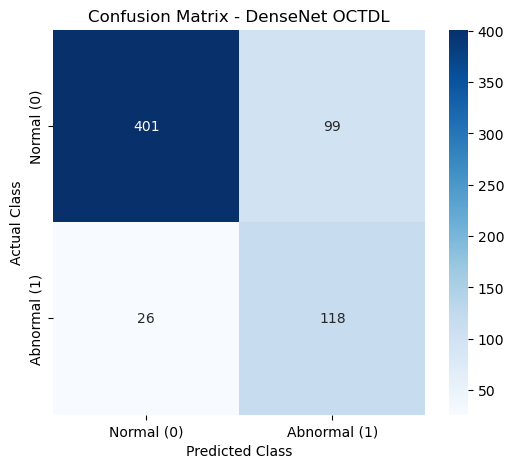

Classification Report:
               precision    recall  f1-score   support

      Normal       0.94      0.80      0.87       500
    Abnormal       0.54      0.82      0.65       144

    accuracy                           0.81       644
   macro avg       0.74      0.81      0.76       644
weighted avg       0.85      0.81      0.82       644

✅ Results saved to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/results/denseNet_OCTDL.xlsx


In [7]:
# DATASET = OCTDL
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

# Disable GPU if Needed
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Dataset Paths (Ensure Correct Case)
dataset_path = "/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/OCTDL"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "validation")
test_dir = os.path.join(dataset_path, "test")

# Constants
image_size = 128  # Reduced from 224 for Faster Training
batch_size = 8  # Optimized for Efficient Loading
num_classes = 2  # Binary Classification (Normal vs Abnormal)

# Data Augmentation (Speeds up Convergence)
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0, rotation_range=30, zoom_range=0.1, horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Data Loaders (Enable Fast Loading)
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(image_size, image_size), batch_size=batch_size,
    class_mode="binary", shuffle=True, interpolation="bilinear"
)
val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=(image_size, image_size), batch_size=batch_size,
    class_mode="binary", shuffle=True, interpolation="bilinear"
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=(image_size, image_size), batch_size=batch_size,
    class_mode="binary", shuffle=False, interpolation="bilinear"
)

# Compute Class Weights (Handles Class Imbalance)
labels = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"Updated Class Weights: {class_weight_dict}")

# Load DenseNet121 (Freeze for First Few Epochs)
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))
base_model.trainable = False  # Freeze Initially

# Define Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")  # Binary Classification Output
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

# Callbacks
model_save_path = "/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/models/denseNet_OCTDL_best.keras"
checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
csv_logger = CSVLogger("/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/training/denseNet_OCTDL.csv", append=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, verbose=1, min_lr=1e-6)

# Train Model (Enable Multiprocessing)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # Reduced for Faster Training
    class_weight=class_weight_dict,
    callbacks=[checkpoint, early_stopping, csv_logger, reduce_lr],
    verbose=1
)

# Load Best Model
model = load_model(model_save_path)

# Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate Predictions
predictions = model.predict(test_generator)
binary_predictions = (predictions > 0.5).astype(int).flatten()
true_labels = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(true_labels, binary_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal (0)", "Abnormal (1)"],
            yticklabels=["Normal (0)", "Abnormal (1)"])
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix - DenseNet OCTDL")
plt.show()

# Classification Report
report = classification_report(true_labels, binary_predictions, target_names=["Normal", "Abnormal"], output_dict=True)
print("Classification Report:\n", classification_report(true_labels, binary_predictions, target_names=["Normal", "Abnormal"]))

# Save Results to Excel
excel_file = "/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/results/denseNet_OCTDL.xlsx"
results_df = pd.DataFrame({
    "Dataset": ["OCTDL"],
    "Model": ["DenseNet"],
    "Test Accuracy": [test_accuracy],
    "Test Loss": [test_loss],
    "Precision": [report["weighted avg"]["precision"]],
    "Recall": [report["weighted avg"]["recall"]],
    "F1-Score": [report["weighted avg"]["f1-score"]]
})

try:
    if os.path.exists(excel_file):
        existing_df = pd.read_excel(excel_file)
        results_df = pd.concat([existing_df, results_df], ignore_index=True)
except FileNotFoundError:
    pass  # If the file does not exist, it will be created

results_df.to_excel(excel_file, index=False)
print(f"✅ Results saved to {excel_file}")
